In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import (
    LinearRegression, 
    Ridge, Lasso)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import (
    GradientBoostingRegressor, 
    AdaBoostRegressor, 
    ExtraTreesRegressor)

from sklearn.metrics import (
    mean_squared_error,
    r2_score, 
    mean_absolute_error)

In [2]:
df = pd.read_csv("../data/train_data.csv")
# ds = ds.sample(frac=0.2, random_state=42)

X = df[["Attrition_Flag","Customer_Age","Gender","Dependent_count",
             "Education_Level","Marital_Status","Income_Category","Card_Category",
             "Months_on_book","Total_Relationship_Count","Months_Inactive_12_mon",
             "Contacts_Count_12_mon","Credit_Limit","Total_Revolving_Bal",
             "Avg_Open_To_Buy","Total_Amt_Chng_Q4_Q1","Total_Trans_Amt",
             "Total_Trans_Ct","Total_Ct_Chng_Q4_Q1"]]

y = df["Avg_Utilization_Ratio"]

In [3]:
# Split the transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
lm = LinearRegression()
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 42)
dtree = DecisionTreeRegressor(random_state = 42)
gbm = GradientBoostingRegressor(random_state=42)
abr = AdaBoostRegressor(random_state=42)
etr = ExtraTreesRegressor(random_state=42)


algo = [lm,ridge,lasso, knn, rf, dtree, gbm, abr, etr]

result = []

for i in algo:
        start = time.process_time()
        ml_model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), ml_model.score(X_train, y_train), ml_model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, ml_model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, ml_model.predict(X_test))),
                  mean_absolute_error(y_train, ml_model.predict(X_train)),
                  mean_absolute_error(y_test, ml_model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(round(time.process_time()-start,3)),"sec")

result = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
result

LinearRegression ✓     0.031 sec
Ridge ✓     0.031 sec
Lasso ✓     0.031 sec
KNeighborsRegressor ✓     2.438 sec
RandomForestRegressor ✓     15.312 sec
DecisionTreeRegressor ✓     0.203 sec
GradientBoostingRegressor ✓     3.922 sec
AdaBoostRegressor ✓     1.625 sec
ExtraTreesRegressor ✓     6.156 sec


,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
ExtraTreesRegressor_baseline,1.000000,0.999953,5.246686e-16,0.001917,3.195217e-16,0.001081
RandomForestRegressor_baseline,0.999963,0.999727,1.663379e-03,0.004616,8.966358e-04,0.002356
DecisionTreeRegressor_baseline,1.000000,0.998897,5.865341e-18,0.009270,5.182754e-19,0.005213
GradientBoostingRegressor_baseline,0.998822,0.998605,9.383940e-03,0.010426,6.792918e-03,0.007352
AdaBoostRegressor_baseline,0.982942,0.984274,3.570976e-02,0.035007,3.022220e-02,0.029303
KNeighborsRegressor_baseline,0.817961,0.725919,1.166555e-01,0.146147,8.083022e-02,0.103171
Ridge_baseline,0.661404,0.656718,1.590979e-01,0.163559,1.334018e-01,0.137007
LinearRegression_baseline,0.661508,0.656608,1.590734e-01,0.163585,1.334046e-01,0.136982
Lasso_baseline,0.000000,-0.000165,2.734156e-01,0.279181,2.365517e-01,0.241843


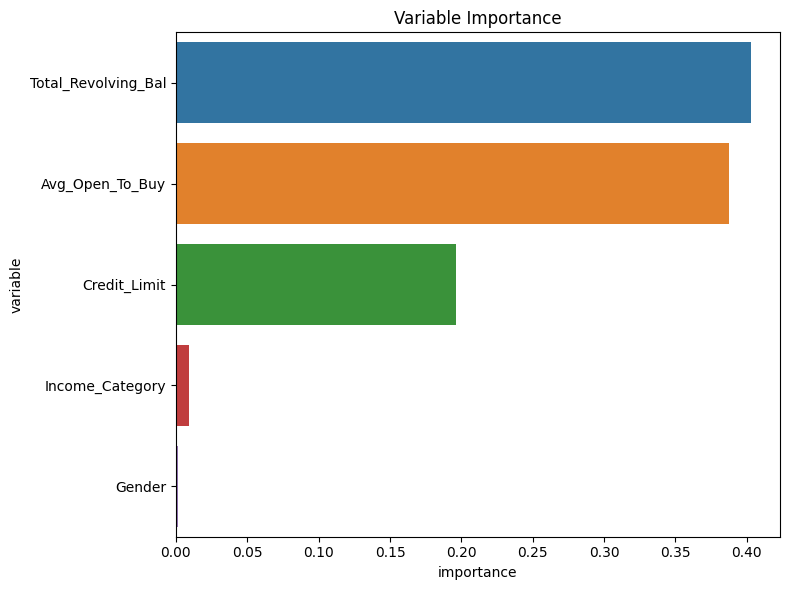

In [7]:
rankings = ml_model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),
                          columns=["variable","importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
            y="variable",
            data=importance[:5])
plt.title('Variable Importance')
plt.tight_layout()

In [8]:
filename = '../models/best_model.sav'
pickle.dump(etr, open(filename, 'wb'))

In [16]:
from datetime import datetime 
from sklearn.model_selection import GridSearchCV

In [11]:
etr_ = ExtraTreesRegressor(random_state=42)

In [26]:
param_grid = {
    'n_estimators': [10,50,100],
    'max_depth': [2,8,16,32,50],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2],
    'max_features': ['auto','sqrt','log2'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

In [27]:
tuning_model = GridSearchCV(etr_, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=3)

In [28]:
def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        print(thour,":",tmin,':',round(tsec,2))

In [29]:
start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV 1/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n

[CV 1/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=nan total time=   0.0

[CV 3/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True;, score=-0.047 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True;, score=-0.048 

[CV 1/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.046 to

[CV 1/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, score=-0.046 to

[CV 2/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.046 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.045 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=False;, score=-0.046 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=False;, score=-0.046 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=False;, score=-0.045 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.047 to

[CV 1/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=-0.047 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=-0.048 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=-0.046 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=nan total ti

[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=nan total time=   0

[CV 3/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.008 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.010 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.008 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.010 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.010 

[CV 3/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.010 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 to

[CV 3/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.010 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.010 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.008 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.010 to

[CV 3/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.010 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 to

[CV 1/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total ti

[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0

[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.003 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.003 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.002 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.002 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.

[CV 1/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score=

[CV 1/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.002 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.002 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.002 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.002 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.002 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=

[CV 2/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time

[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.

[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0

[CV 3/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, scor

[CV 3/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.

[CV 1/3] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.001 to

[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=False;, score

[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.

[CV 3/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.

[CV 3/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score

[CV 1/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;, score=nan total ti

[CV 2/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.048 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0

[CV 3/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.045 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.046 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.047 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.045 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.047 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.

[CV 3/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.046 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.047 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.048 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.046 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.046 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=True;, score

[CV 3/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.047 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.048 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.046 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.047 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, scor

[CV 3/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   

[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.010 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.007 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.

[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.008 total time=   0.2s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.010 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.008 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.010 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.010 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0

[CV 1/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.009 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.010 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.009 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.009 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.010 total time=   0.2s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, sco

[CV 2/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.009 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.008 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.008 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.009 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.008 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0

[CV 3/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=nan total 

[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.5s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, warm_start=False;, sco

[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.003 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10, warm_start=False;, s

[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.6s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=False;,

[CV 1/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, sco

[CV 3/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.2s
[CV 2/3] END bootstrap=False, max_depth=16, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=True;, sco

[CV 1/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=50, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, warm_start=True;, score=nan total

[CV 3/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.001 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50, warm_start=False;, sco

[CV 3/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=False;, sc

[CV 3/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.1s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;, score=-0.001 total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;

[CV 3/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.5s
[CV 2/3] END bootstrap=False, max_depth=32, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, sco

[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100, warm_start=False;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=10, warm_start=True;, score=nan total

[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.1s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.1s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, warm_start=False;,

[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.6s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=True;, score=-0.001 total time=   0.5s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, score=-0.001 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50, warm_start=False;, sco

[CV 2/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=True;, score=-0.001 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=True;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.001 total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.001 total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=10, warm_start=False;, score=-0.002 total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50, warm_start=True;, sco

[CV 2/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=-0.001 total time=   1.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=True;, score=-0.001 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=False;, score=-0.001 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=False;, score=-0.001 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, warm_start=False;, score=-0.001 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=10, warm_start=True;

D:\Python\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Python\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\Python\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\Python\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_c

0.0 : 13.0 : 18.62


In [30]:
tuning_model.best_params_

{'bootstrap': False,
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'warm_start': True}

In [31]:
tuning_model.best_score_

-0.000562248767019133

In [5]:
tuned_hyper_model = ExtraTreesRegressor(
bootstrap = False,
max_depth = 32,
max_features = 'sqrt',
min_samples_leaf = 1,
min_samples_split = 2,
n_estimators = 100,
warm_start = True)

In [6]:
tuned_hyper_model.fit(X_train,y_train)

ExtraTreesRegressor(max_depth=32, max_features='sqrt', warm_start=True)

In [7]:
filename = '../models/finalized_model.sav'
pickle.dump(tuned_hyper_model, open(filename, 'wb'))